In [8]:
import pickle
import json
import mmcv
from tqdm import tqdm_notebook as tqdm
from mmdet.datasets import build_dataloader, build_dataset
from pycocotools.coco import COCO
import pycocotools.coco as cocoapi
import pycocotools.mask as MASK
import os
import cv2
from icecream import ic
import matplotlib.pyplot as plt
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint, get_dist_info
import numpy as np
def get_original_size(name):
    datadir = "/home/xfr/rssid/data/val/images/"
    files = os.listdir(datadir)
    img_name = ""
    for file in files:
        img_name = file.split(".")[0]
        if(img_name == name):
            break
    filename = os.path.join(datadir, file)
    img = cv2.imread(filename)
    h, w, _ = img.shape
    return h,w
cfg = mmcv.Config.fromfile("/home/xfr/git_mm/mmdetection/configs/rs_cascade_mask_rcnn_r50_fpn_ohem.py")
dataset = build_dataset(cfg.data.test)
CLASSES = ('tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane','ground-track-field',
               'helicopter', 'airport','harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field',
               'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad')
results = mmcv.load("/home/xfr/git_mm/mmdetection/result/noise.pkl")
img_infos = dataset.load_annotations("/home/xfr/mmdetection/data/rscup/annotation/annos_rscup_noise.json")
ann = {}
last_name = ""
last = ""
hard = []
for i in tqdm(range(len(results))):
    result = results[i]
    bboxes = result[0]
    segs = result[1]
    filename = img_infos[i]['filename']
    if filename not in ann:
        ann[filename] = {"rect": [], "bbox": []}
    img = cv2.imread("/home/xfr/git_mm/mmdetection/data/rscup/noise/" + filename)
    h, w, _ = img.shape
   
    for cls in range(18):
        bbox_cls = bboxes[cls]
        seg_cls = segs[cls]
        if( len(bbox_cls) > 0):
            hard.append(filename)
            for bbox, rle in zip(bbox_cls, seg_cls):
                xmin, ymin, xmax, ymax, score = bbox
                mask = MASK.decode(rle)
                contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                                 cv2.CHAIN_APPROX_SIMPLE)
                areas = [cv2.contourArea(contour)  for contour in contours]
                if(len(areas) > 0):
                    index = np.argmax(areas)
                    contour = contours[index]
                    rect = cv2.minAreaRect(contour)
                    poly = cv2.boxPoints(rect)
                else:
                    continue
                ann[filename]['rect'].append(poly)
                ann[filename]["bbox"].append([xmin, ymin, xmax, ymax])
mmcv.dump(ann, "./result/pre_noise.pkl")

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [3]:
import pickle
import json
import mmcv
from tqdm import tqdm_notebook as tqdm
from mmdet.datasets import build_dataloader, build_dataset
from pycocotools.coco import COCO
import pycocotools.coco as cocoapi
import pycocotools.mask as MASK
import os
import cv2
from icecream import ic
import matplotlib.pyplot as plt
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint, get_dist_info
import numpy as np

In [7]:
print(len(hard))

23159


In [6]:
CLASS=['tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad', 'noise']
class_to_ind = dict(zip(CLASS, range(len(CLASS))))
print(class_to_ind)
ann = mmcv.load("./result/pre_noise.pkl")
info2 = {
    "description": "rscup",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2014,
    "contributor": "COCO Consortium",
    "date_created": "2017/09/01"
  }
license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
categories = []
for cls in CLASS:
    category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
    categories.append(category)
print(categories)
annotations = {"info": info2, "images": [], "annotations": [], "categories":categories, "license":license}
obj_id = 0
ID = 0
for img_name in tqdm(ann.keys()):
    img = cv2.imread("/home/xfr/git_mm/mmdetection/data/rscup/noise/" + img_name)
    H, W, _ = img.shape
    image = { "license": 1,
                      "file_name": img_name,
                      "coco_url": "xxx",
                      "height": H,
                      "width": W,
                      "date_captured": "2019-06-25",
                      "flickr_url": "xxx",
                      "id": ID
                    }
    boxes = ann[img_name]['bbox']
    polys = ann[img_name]['rect']
    for box, poly in zip(boxes, polys):
        x1, y1, x2, y2 = box
        area = (x2-x1)*(y2-y1)
        poly = poly.flatten()
        annotation = {"id" : obj_id, 
                "image_id" : ID, 
                "category_id" : class_to_ind['noise'], 
                "segmentation" : [poly], 
               "area" :  area, 
               "bbox" : [x1, y1, x2-x1, y2-y1], 
               "iscrowd" : 0,
            }
        obj_id += 1
        annotations["annotations"].append(annotation)
    ID += 1
    cv2.imwrite("./data/rscup/{}/".format("background")+img_name, img)
    annotations["images"].append(image)

with open('./data/rscup/annotation/annos_rscup_'+"background"+'.json', 'w') as json_file:
    json.dump(annotations, json_file, cls=MyEncoder)
print("totol number {}".format(str(ID)))    


{'tennis-court': 0, 'container-crane': 1, 'storage-tank': 2, 'baseball-diamond': 3, 'plane': 4, 'ground-track-field': 5, 'helicopter': 6, 'airport': 7, 'harbor': 8, 'ship': 9, 'large-vehicle': 10, 'swimming-pool': 11, 'soccer-ball-field': 12, 'roundabout': 13, 'basketball-court': 14, 'bridge': 15, 'small-vehicle': 16, 'helipad': 17, 'noise': 18}
[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercate

NameError: name 'MyEncoder' is not defined

In [7]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)
with open('./data/rscup/annotation/annos_rscup_'+"background"+'.json', 'w') as json_file:
    json.dump(annotations, json_file, cls=MyEncoder)

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
[18]
{'license': 1, 'file_name': 'P4851_1_2080.0_1248.0_part34.jpg', 'coco_url': 'xxx', 'height': 511, 'width': 511, 'date_captured': '2019-06-25', 'flickr_url': 'xxx', 'id': 47756}
2
[{'id': 26238, 'image_id': 47756, 'category_id': 18, 'segmentation': [[392.0, 286.0, 392.0, 279.0, 419.0, 279.0, 419.0, 286.0]], 'area': 218.95358276367188, 'bbox': [392.7632141113281, 278.40972900390625, 26.718719482421875, 8.19476318359375], 'iscrowd': 0}, {'id': 26239, 'image_id': 47756, 'category_id': 18, 'segmentation': [[392.0, 286.0, 392.0, 279.0, 419.0, 279.0, 419.0, 286.0]], 'area': 217.32994079589844, 'bbox': [392.7444152832031, 278.3947448730469, 26.903717041015625, 8.07806396484375], 'iscrowd': 0}]


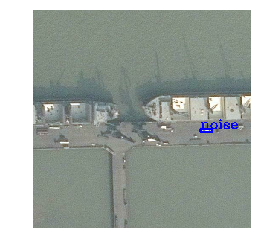

In [140]:
# get all images containing given categories, select one at random
import sys
sys.path.append('D:\API\cocoapi\PythonAPI')  # 你下载的 cocoapi 所在路径
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
coco=COCO("./data/rscup/annotation/annos_rscup_background.json")
catIds = coco.getCatIds(catNms=['noise'])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
# imgIds = coco.getImgIds(imgIds=[335328])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
I = io.imread('./data/rscup/noise/'+img['file_name'])
plt.imshow(I)
plt.axis('off')
print(img)
annIds = coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
print(len(annIds))
anns = coco.loadAnns(annIds)
print(anns)
for ann in anns:
    bbox = ann['bbox']
    poly = np.array(ann["segmentation"][0]).reshape(4,2)
    x = [int(x) for x in bbox]
    cv2.rectangle(I, (x[0],x[1]), (x[0]+x[2],x[1]+x[3]), (0,255,0), 2)
    cv2.polylines(I, np.array([poly], np.int32), 1, (0, 0, 255), 3)
    #cv2.fillPoly(I, np.array([poly], np.int32),(0.,255,0) )
    cv2.putText(I, CLASS[ann['category_id']], (x[0],x[1]), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
plt.imshow(I)
#coco.showAnns(anns)